In [6]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator


import matplotlib.pyplot as plt
import pandas as pd
import torch


import numpy as np
import os
from google.colab import drive

# Подключение к Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
dirname = "/content/drive/MyDrive/Colab Notebooks/data/underwork"

raw_data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}
for v in raw_data:
    tsdf_c = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    tsdf_w = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    raw_data[v] = (tsdf_c, tsdf_w, tsdf_m)

data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}

for v in raw_data:
    calm = raw_data[v][0]
    work = raw_data[v][1]
    sex = raw_data[v][2].iloc[0]["values"]
    weight = raw_data[v][2].iloc[1]["values"]
    height = raw_data[v][2].iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    data[v] = (calm, work)

validation = {"25":(), "27":()}
for v in validation:
    calm = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    work = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    sex = tsdf_m.iloc[0]["values"]
    weight = tsdf_m.iloc[1]["values"]
    height = tsdf_m.iloc[2]["values"]
    calm["sex"] = sex
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work["sex"] = sex
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    validation[v] = (calm, work)

ts = pd.DataFrame()

for v in data:
   calm = data[v][0]
   work = data[v][1]
   ts = pd.concat([ts, calm, work], sort=False, axis=0)

ts.index = np.arange(len(ts.index))
ts.index = pd.to_datetime(ts.index)
sec = 1000000000
delta = pd.to_datetime(2 * sec) - pd.to_datetime(sec)
times = [pd.to_datetime(sec)]
for i in range(1, len(ts.index)):
    times += [times[i - 1] + delta]
ts.index = times

pdts_data = PandasDataset(ts, freq='S', target='1')
test_size = 5000
train,test = split(pdts_data, offset=-test_size)

EPOCHS = 1
model = DeepAREstimator(freq='S', prediction_length=test_size, trainer_kwargs={'max_epochs':EPOCHS})

In [8]:
predictor = model.train(train)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name  | Type        | Params | In sizes                                                           | Out sizes     
----------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | [[1, 1], [1, 1], [1, 5181, 7], [1, 5181], [1, 

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.57843 (best 0.57843), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 0.57843 (best 0.57843), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [9]:
test = test.generate_instances(prediction_length = test_size, windows=1)
forecast = list(predictor.predict(test.input))

1


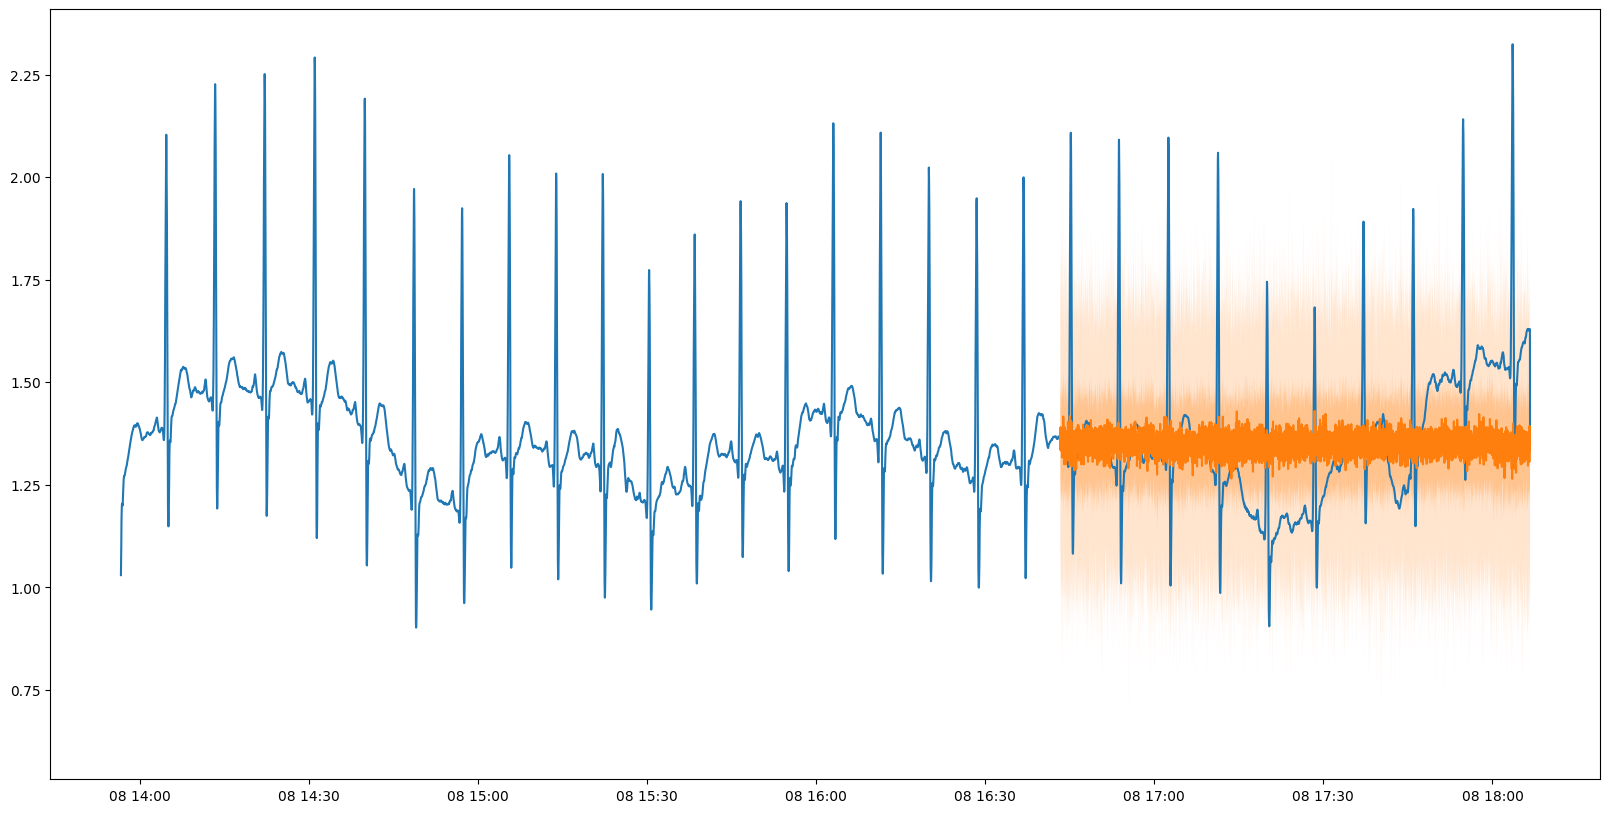

In [10]:
plt.figure(figsize=(20,10))
print(len(forecast))
plt.plot(ts['1'][len(ts['1']) - 3 * test_size:len(ts['1'])])
for fore in forecast:
    fore.plot()